<h1>Fitting IVT mechanistic model to new data<h1>

In this notebook, we will be showing how to use fit the model presented in our work to new data. We will demonstrate:
    
    1. Plotting model predictions against data the model has not seen before
    2. Incorporating new data into the fitting process and re-performing parameter estimation
    3. Visualizing model fitting by plotting against new data
    4. Using new parameters for hypothesis testing

<b>1. Importing required packages<b>

In [15]:
using Pkg
Pkg.activate("IVTmodel")
using Distributed
using DifferentialEquations
using Plots
using NLopt
using LinearAlgebra
using Metrics
using CSV, DataFrames
using StaticArrays
using ForwardDiff
using NamedTupleTools
using BenchmarkTools
using ComponentArrays
using Distributions
using Statistics
using GenericLinearAlgebra
using DiffResults
using FLoops
using SharedArrays
using Plots.PlotMeasures
using FlexiMaps
using LaTeXStrings
using DelimitedFiles
using StatsBase
using NLsolve

include("./modules/model.jl")
include("./modules/parameterbackend.jl")
include("./modules/akamadataprocessing.jl")
include("./modules/akamaplotting.jl")
include("./modules/IVTplotting.jl")
include("./modules/modelfitting.jl")
include("./modules/residualcalculation.jl")
include("./modules/parameteruncertainty.jl")
include("./modules/predictionuncertainty.jl")
include("./modules/akamasensitivity.jl");

  Activating project at `C:\Users\ChemeGrad2021\Documents\Braatz Group\MRNA Synthesis\Published code\IVTmechanisticmodel\IVTmodel`


In [2]:
#Generates settings for parameters used
fittingmodel = setupmodel()
#Imports calibration data from csv files
modeldata = importakamadata()
#Imports PPiase validation data
PPiasedata = importakamaPPiasedata();

<b>2: Importing fitted parameters and covariance matrix from fitting solely on Akama dataset<b>

    We will inport the parameters generated in the other notebook to predict the output of a new dataset. 

In [3]:
akamafittedparametersmatrix = Matrix(CSV.read("outputs/fittedparameters.csv", DataFrame,header=false))
akamafittedparameterslist = reshape(akamafittedparametersmatrix,(size(akamafittedparametersmatrix)[1],))
akamafittedcovariancematrix = Matrix(CSV.read("outputs/covariancematrix.csv", DataFrame,header=false))
akamafittedparams = fullparameterset(fittingmodel,akamafittedparameterslist)
printresidual(fittingmodel,modeldata,akamafittedparameterslist)

Total Residual:                        750.5
Components of residual:
Concentration Trajectories (Figure 2): 323.1
Initial Reaction Rate (Figure 3A):     160.5
Mg2PPi solubility (Figure 3B):         200.4
Parameter priors:                      66.5


<b>3: Plotting Akama fitting against Akama data<b>

   For comparison to later sections of this notebook, shown here is the Akama calibration data with the Akama fit. These are the same figures presented in the main body of our paper. 

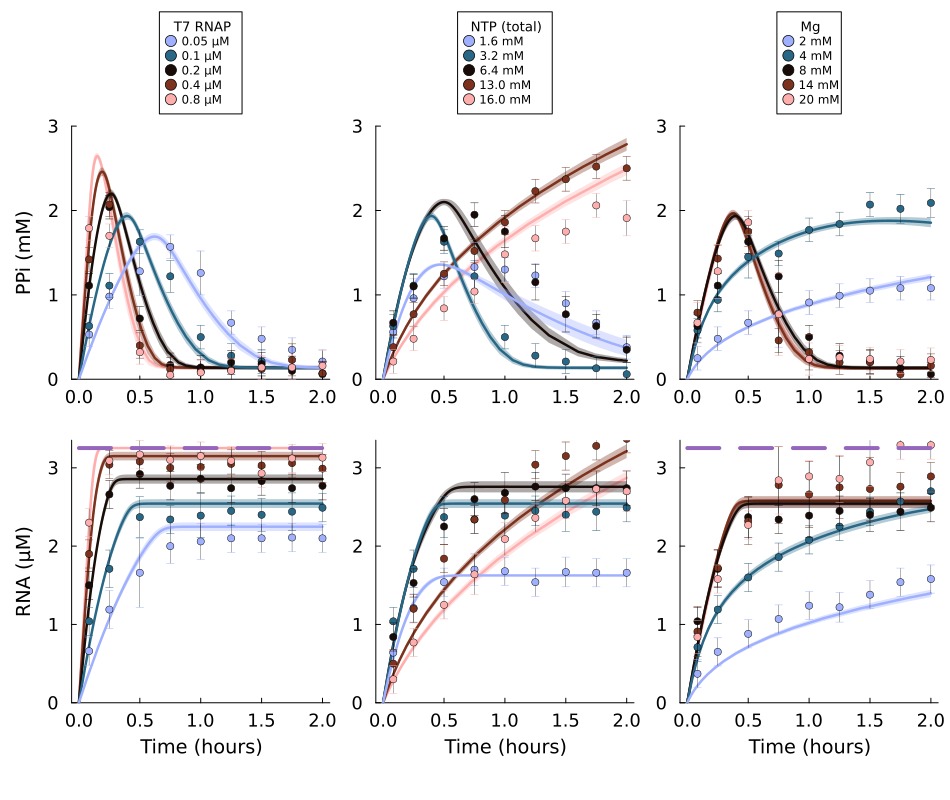

In [16]:
plt = revision1plot1(fittingmodel,modeldata, akamafittedparams, akamafittedcovariancematrix, true,true)

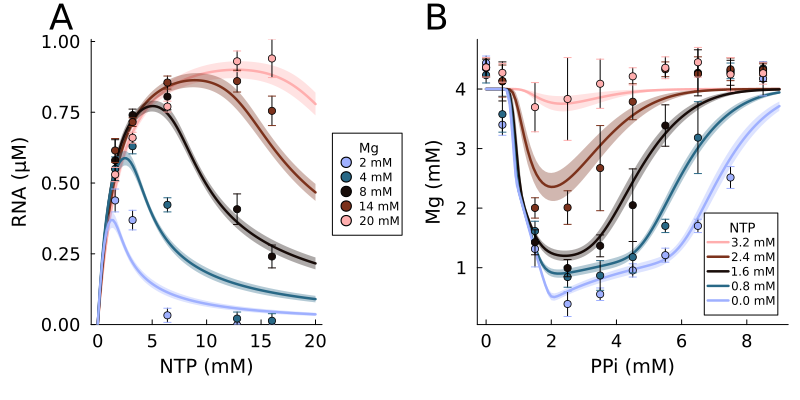

In [5]:
plt = revision1plot2(fittingmodel,modeldata, akamafittedparams, akamafittedcovariancematrix, true,true)

<b>4: Plotting Akama fitting against new data<b>
    
First, we define the file containing our new data. The data we are adding here was collected using initial NTP concentrations of ~25 mM. That is outside of the range our model was calibrated on, meaning that we are extrapolating. Our predictions on this data are incorrect with large uncertainty. 

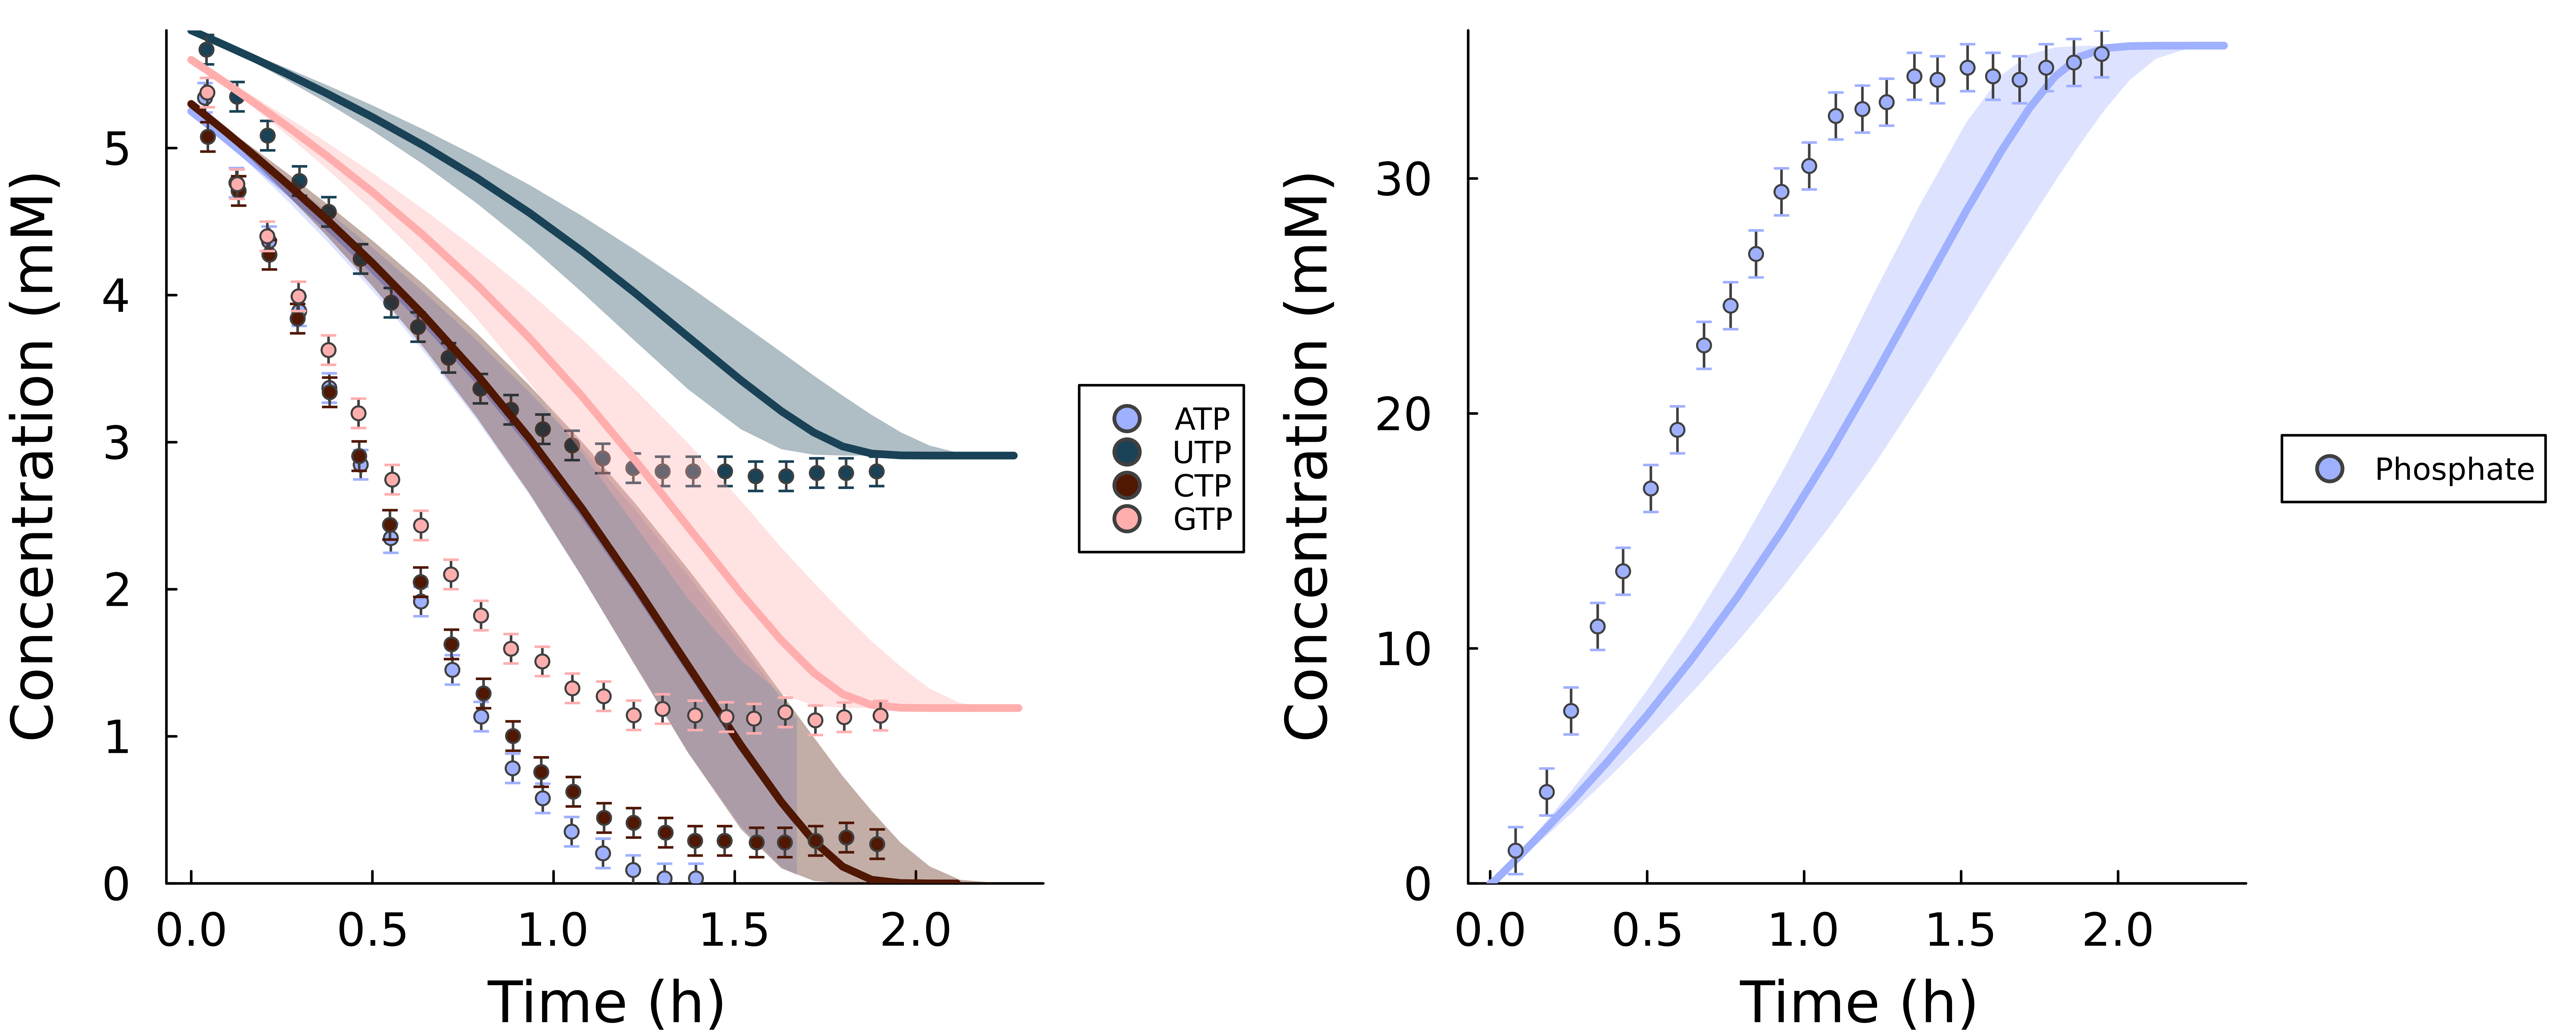

In [6]:
filename = "data/pfizerNTP.csv"
pfizerplot1 = plotfromcsv(fittingmodel,akamafittedparameterslist,akamafittedcovariancematrix,filename, range = 1:4,dataerrorbars = true, maximumyield = false, plotsize = (500,400),labels = ["ATP","UTP","CTP","GTP",], multiplot = false)
pfizerplot2 = plotfromcsv(fittingmodel,akamafittedparameterslist,akamafittedcovariancematrix,filename,range = 5:5,dataerrorbars = true, maximumyield = false, plotsize = (500,400),labels = ["Phosphate","RNA"])
pfizerplotfull1 = plot(pfizerplot1,pfizerplot2, size = (1000,400), leftmargin = 5mm, bottommargin = 5mm,dpi=1000)
savefig(pfizerplotfull1,"figures/pfizerdata_unfitted.png")
pfizerplotfull1

<b>4: Fitting combined Akama + new dataset<b>

We will first evaluate the residual of applying this model to the existing Akama dataset and our new data. Unsuprisingly, the loss associated with our new data is much greater than any other source.

In [7]:
printresidual(fittingmodel,modeldata,akamafittedparameterslist,customfile = true,customfilename = filename)

Total Residual:                        18919.2
Components of residual:
Concentration Trajectories (Figure 2): 323.1
Initial Reaction Rate (Figure 3A):     160.5
Mg2PPi solubility (Figure 3B):         200.4
Parameter priors:                      66.5
Custom Data:                           18168.7


<b>5: Optimizing model with new dataset<b>

In [8]:
res = (model,data,x) -> customresidualeval(model,data,filename,x)
optim=localopt(fittingmodel, modeldata,300,akamafittedparameterslist,res,verbose = true)
customfittedparamslist = optim[4]
customfittedparams = fullparameterset(fittingmodel,customfittedparamslist)
customcovariancemat = getcovariancematrix(fittingmodel,modeldata,customfittedparamslist,customfile = true,customfilename = filename)
writedlm( "outputs/customfittedparameters.csv",  customfittedparamslist, ',')
writedlm( "outputs/customcovariancematrix.csv",  customcovariancemat, ',')


18919.455712976105
69890.48168721727
5480.988884254868
3936.659457936764
3459.675148994695
3032.316781344081
2373.7822976918724
2120.3447817008046
1963.1566360456204
1893.0679703424166
1863.1859454538796
1723.1681473205672
1514.4593611022285
1469.8546715800107
1460.835629763892
1438.836193133511
1420.9478657586194
1404.8656497493619
1383.8887407439875
1364.280303415691
1359.9479850680007
1355.007547724811
1353.733824755945
1350.8268442808721
1345.6813307282164
1335.4442538258563
1325.6247198672388
1317.199053152031
1313.3933279350101
1312.598842930635
1311.4810618448757
1307.4852808937849
1304.494620697497
1300.2706447210332
1298.330273381657
1296.1655803703022
1293.3895719606498
1292.757043940444
1292.6170029202976
1292.4819953552255
1292.0732319307454
1291.3718100660785
1290.3010014509362
1289.2736852465882
1288.7605471652996
1288.617059798983
1288.504971954311
1288.3167981084584
1288.1077034285088
1287.9567111845386
1287.868994646497
1287.7893850430964
1287.6427891822427
1287.418159

The fitting process has dramatically decreased our overall loss, specifically the loss associated with our new data. 

In [9]:
printresidual(fittingmodel,modeldata,customfittedparamslist,customfile = true,customfilename = filename)

Total Residual:                        1285.2
Components of residual:
Concentration Trajectories (Figure 2): 353.8
Initial Reaction Rate (Figure 3A):     257.8
Mg2PPi solubility (Figure 3B):         201.2
Parameter priors:                      63.4
Custom Data:                           409.0


<b>6: Plotting Figures with new parameter fitting<b>
    
Once we have performed fitting, it is important to check whether our fits to the original data set are reasonable. If the model cannot fit both the original dataset and the new data, it is a sign that the model structure or original data is somehow incongruent with the new data. In this case, the model is able to reasonably fit both the original and new datasets. 

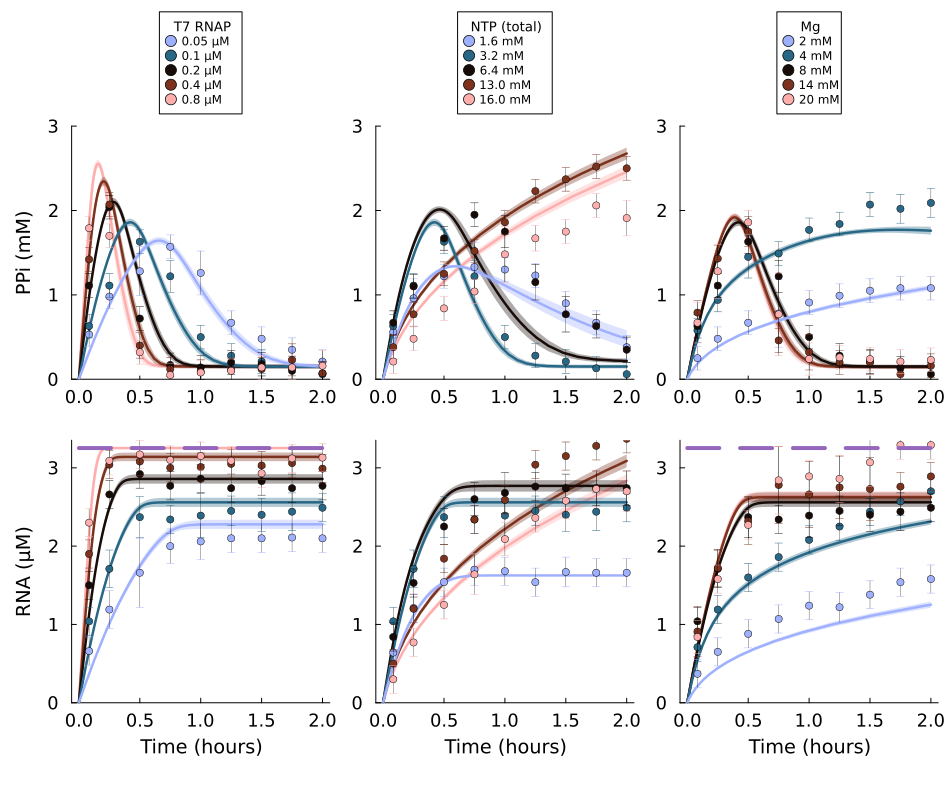

In [10]:
plt = revision1plot1(fittingmodel,modeldata, customfittedparams, customcovariancemat, true,true)

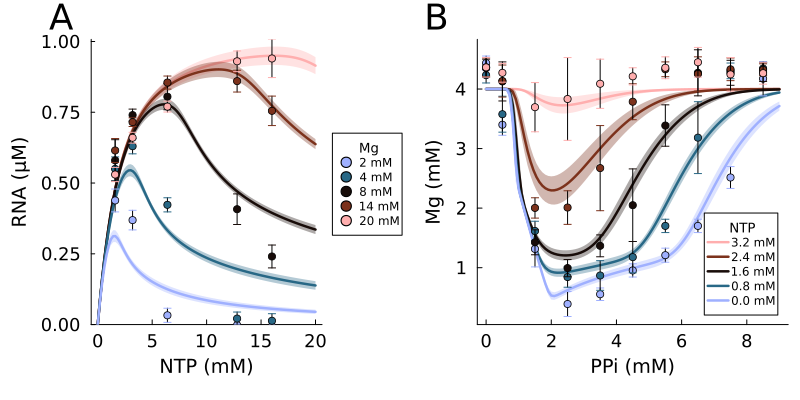

In [11]:
plt = revision1plot2(fittingmodel,modeldata, customfittedparams, customcovariancemat, true,true)

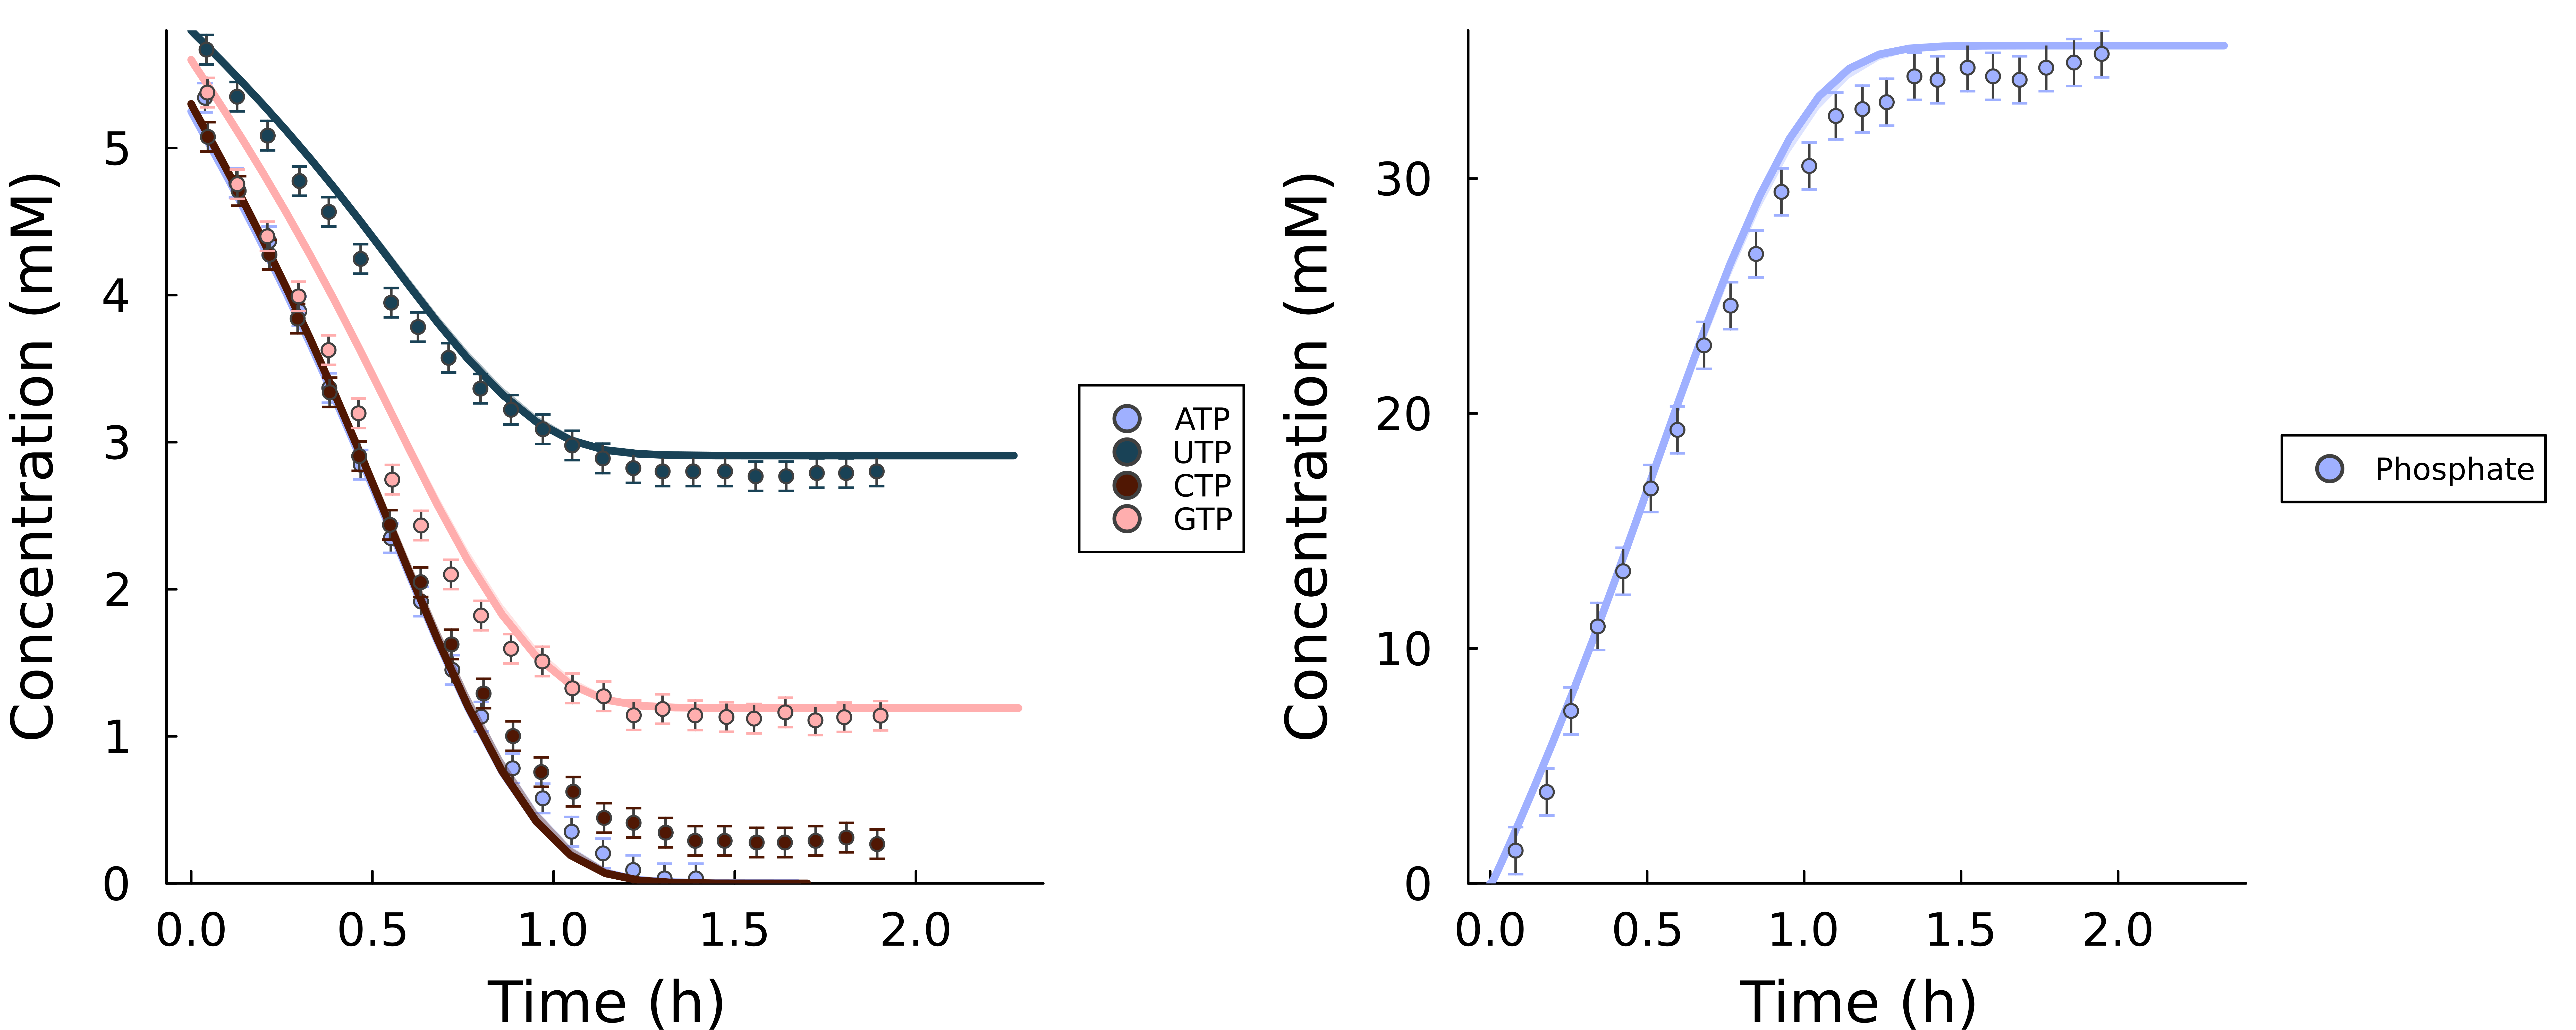

In [12]:
pfizerplot21 = plotfromcsv(fittingmodel,customfittedparamslist, customcovariancemat,"data/pfizerNTP.csv",range = 1:4,dataerrorbars = true, maximumyield = false, plotsize = (800,600),labels = ["ATP","UTP","CTP","GTP",], multiplot = false)
pfizerplot22 = plotfromcsv(fittingmodel,customfittedparamslist, customcovariancemat,"data/pfizerNTP.csv",range = 5:5,dataerrorbars = true, maximumyield = false, plotsize = (500,400),labels = ["Phosphate","RNA"])
pfizerplotfull2 = plot(pfizerplot21,pfizerplot22, size = (1000,400), leftmargin = 5mm, bottommargin = 5mm,dpi=1000)
savefig(pfizerplotfull2,"figures/pfizerdata_fitted.png")
pfizerplotfull2

<b>7: Hypothesis testing with new model<b>

Now that we have a model that is appropriate for all of our data, we can start using it to answer mechanistic questions. One possible question is the effect of removing pyrophosphate from the reaction scheme used in the new data (researchers originally used 2 U/ml). We use a new file for inputting this into our model. 

As we would expect from our previous data, in the absence of the pyrophosphatase enzyme, magnesium pyrophosphate crystallization halts the reaction and prevents it from reaching full yield. 

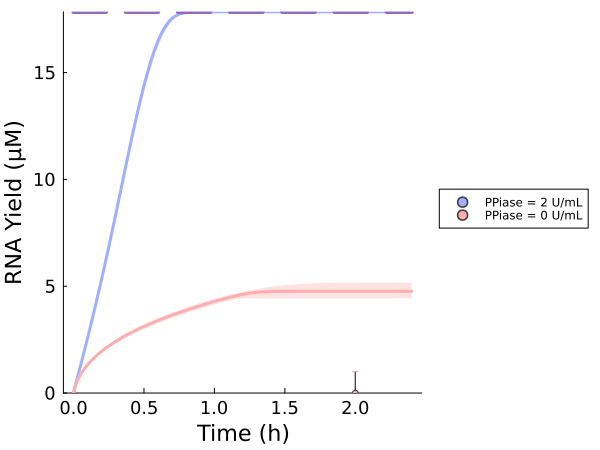

In [18]:
hypothesistestingfilename = "data/pfizertest.csv"
testrange = 1:2
lab = ["PPiase = 2 U/mL", "PPiase = 0 U/mL"]
pfizerplot = plotfromcsv(fittingmodel,customfittedparamslist, customcovariancemat,hypothesistestingfilename, plotsize = (600,450), multiplot = false, range = testrange,dataerrorbars = true, maximumyield = true,labels = lab)
savefig(pfizerplot,"figures/ppiasehypothesistesting.png")
pfizerplot